# Analiza przekazu medialnego na temat społeczności LGBT na przykładach portali internetowych

## Ten internet news and opinion services were chosen as a base for analysis. Ideologically portals lean from left to right, with two catholic outlets, one left-wing and one fundamentalist right.

### Aims  
1. Identifying most frequently used words and collocations to learn about the language used in portrayal of LGBT+ issues in polish press. Material can be later used to more detailed, qualitative analysis. 
2. Creation and evaluation of classification model to investigate whether language used in media text is closer to that of right- or left-wing media

### 1. Reading data and preprocessing

In [1]:
# basic libraries
import pandas as pd
import numpy as np
import random
import datetime
import re
import pprint
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
#statistics
from scipy import stats
import scipy.stats as ss

# NLP
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS 
from langdetect import detect
import spacy
from collections import Counter
import nltk
from nltk.collocations import *
import gensim
import gensim.corpora as corpora
from gensim.models.tfidfmodel import TfidfModel
from gensim.corpora.dictionary import Dictionary

# preprocessing, model selections, metrics
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score,RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score,f1_score

# classificators
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
#saving models
import pickle


# scripts
from add_functions import *


In [2]:
# reading data
data_wpolityce = pd.read_csv(r"wpolityce1.csv").dropna().reset_index().drop("index",axis=1)
data_oko = pd.read_csv(r"oko.csv").dropna().reset_index().drop("index",axis=1)
data_niezalezna = pd.read_csv(r"niezalezna.csv").dropna().reset_index().drop("index",axis=1)
data_krypol = pd.read_csv(r"krypol.csv").dropna().reset_index().drop("index",axis=1)
data_kj = pd.read_csv(r"kj.csv").dropna().reset_index().drop("index",axis=1)
data_gazeta = pd.read_csv(r"gazetapeel.csv",lineterminator="\n").dropna().reset_index().drop("index",axis=1)
data_kontakt = pd.read_csv(r"kontakt.csv").dropna().reset_index().drop("index",axis=1)
data_super_express = pd.read_csv(r"se.csv",lineterminator="\n").dropna().reset_index().drop("index",axis=1)
data_pch24 = pd.read_csv(r"pch241.csv",encoding="utf8").dropna().reset_index().drop("index",axis=1)

In [3]:
#removing authors bio from OKO_press articles
data_oko.drop(131,axis=0,inplace=True)
data_oko = data_oko.reset_index().drop("index",axis=1)

for i in range(len(data_oko.Content)):
    data_oko.Content[i] = str(data_oko.Content[i].split(".")[:-6])

#### Parsing dates to datetime format, clearing texts

In [4]:
data_krypol.Date[0] = datetime.datetime(2020, 12, 26, 0, 0)
data_krypol.Date[1] = datetime.datetime(2020, 12, 21, 0, 0)


In [5]:
data_dict = {"wPolityce.pl":data_wpolityce,
             "OKO.press" : data_oko,
             "Niezalezna.pl":data_niezalezna,
             "Krytyka_Polityczna":data_krypol,
             "Klub_Jagiellonski":data_kj,
             "Gazeta.pl":data_gazeta,
             "Kontakt":data_kontakt,
             "Super_Express":data_super_express,
             "Pch24.pl":data_pch24}
for key in data_dict:
    data_dict[key] = parse_dates(data_dict[key])

# removing headers, punctuation, page names, author names etc
for key in data_dict:
    data_dict[key] = clearing_texts(data_dict[key])


In [6]:
# additionaly removing footer from super express and kontakt articles
for i in range(len(data_dict["Super_Express"].Content)):
    data_dict["Super_Express"].Content.iloc[i] = data_dict["Super_Express"].Content.iloc[i][:-140]
for i in range(len(data_dict["Kontakt"].Content)):
    data_dict["Kontakt"].Content.iloc[i] = data_dict["Kontakt"].Content.iloc[i][:-85]
       

In [7]:
data_dict["Kontakt"].iloc[2].Content

'bez rankingów hierarchii i miejsc bez ustalania wspólnej wersji i prób porównywania zasług czy szkód bez aspiracji do wyczerpania listy osób inicjatyw zjawisk czy dzieł kultury które należałoby wyróżnić wskazania poszczególnych redaktorów i redaktorek są osobiste indywidualne niekiedy wskazujące na rzeczy drobne innym razem wieloaspektowe procesy przyjmowana perspektywa lokalna ogólnopolska międzynarodowa również jest zróżnicowana podobnie jak tematyka której dotyczą wręczane prezenty i rózgigłosy zostały opublikowane bez łagodzenia słownictwa ustalania sformułowań i uśredniania ocen i niech tak pozostaniekolejność alfabetyczna ala budzyńskarózga dla przemysława czarnka za straszenie i brak wsparciadługa rózga z dwoma końcami jeden za sprawienie że wizja karania nauczycielek i uczniów za wyznawane poglądy stała się tak realna drugi za brak wystarczającego wsparcia szkół w edukacji zdalnej za niedostrzeganie znikających uczniów braków sprzętu wśród nauczycielek i uczniów idiotyczne dos

### 2. Exploratory analysis

#### 2.1 Plots showing number of articles on lgbt issues published throughout the year

<ipython-input-8-29454201efbc>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))


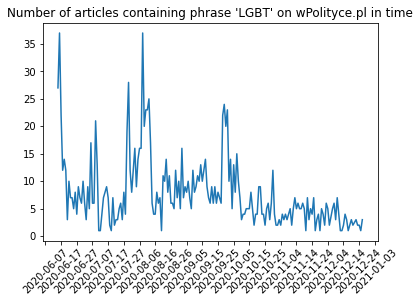

<ipython-input-8-29454201efbc>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))


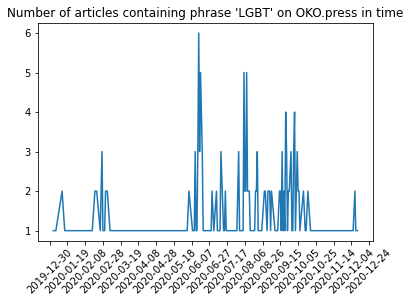

<ipython-input-8-29454201efbc>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))


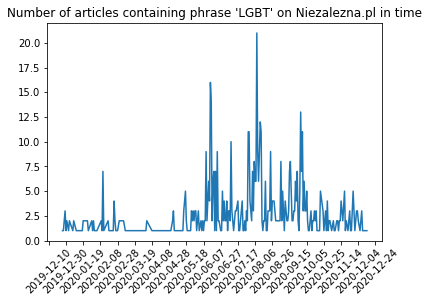

<ipython-input-8-29454201efbc>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))


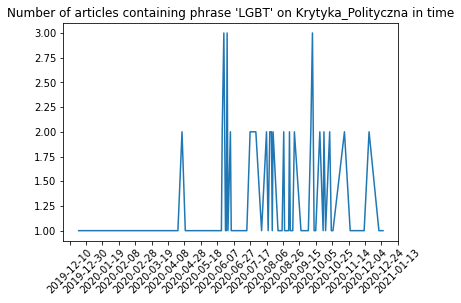

<ipython-input-8-29454201efbc>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))


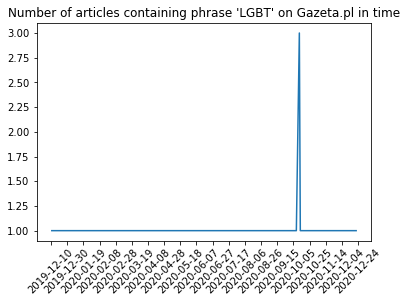

<ipython-input-8-29454201efbc>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))


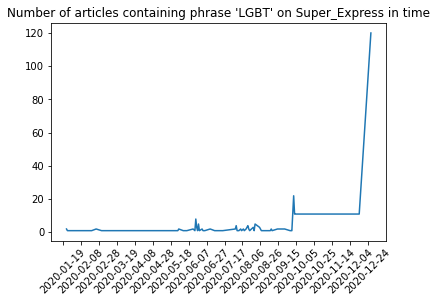

<ipython-input-8-29454201efbc>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))


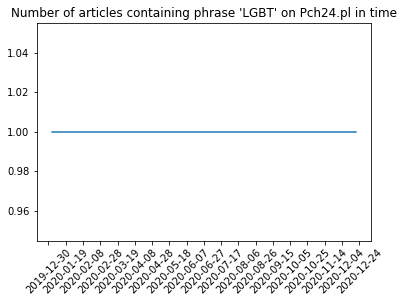

In [8]:

keys = list(data_dict.keys())
for i in range(len(data_dict)):
    if len(data_dict[keys[i]].Content)>100:
        frame = data_dict[keys[i]].sort_values(by="Date")
        grouped = frame.groupby("Date").size()
        plt.plot(grouped.index,grouped.values)
        plt.axes().xaxis.set_major_locator(plt.MaxNLocator(24))
        plt.xticks(rotation=45)
        plt.title(f"Number of articles containing phrase 'LGBT' on {keys[i]} in time")
        plt.show()

#### 2.1 Summary

Charts show couple of "hot" points during the year, where most of the articles were published. They are most visible in data from sites with most publicatons in corpus, mainly wPolityce.pl. These spots are generally consistent with major events in polish public debate. May peak corresponds with planned first round of presidential election, june and july ones happen around actual dates of first and second presidential vote. One from late august corresponds with the arrest of LGBT+ activist Margot and subsequent protests. Peaks around late october were caused by lbgt+ community participation in protests against tightening anti-abortion laws in poland

#### 2.2 Preprocessing for NLP with Spacy and creating word clouds

Word clouds and word frequencies can help us get to know the language that newspaper is using to describe the issues

In [9]:
# loading spacy model for polish 
nlp = spacy.load("pl_core_news_md")

In [10]:
# creating a column containing text processed by spacy in each data frame 
for key in data_dict:
    data_dict[key]["processed"] = 0
    for i in range(len(data_dict[key].Content)):
        data_dict[key]["processed"][i] = nlp(data_dict[key].Content[i])

<ipython-input-10-25d2972400cd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dict[key]["processed"][i] = nlp(data_dict[key].Content[i])
C:\Users\szklarnia\anaconda3\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


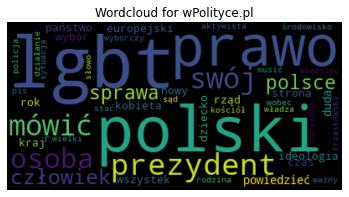

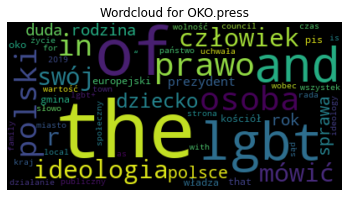

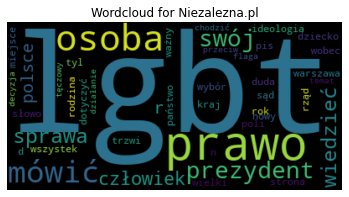

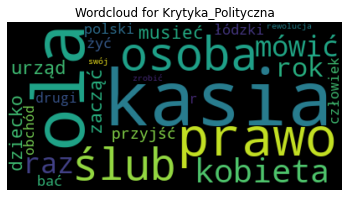

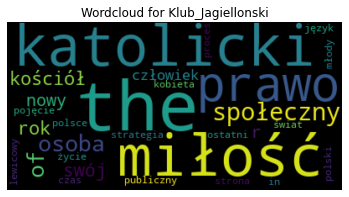

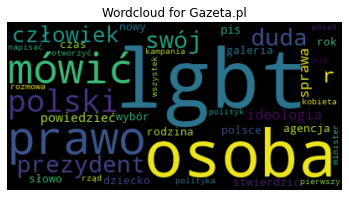

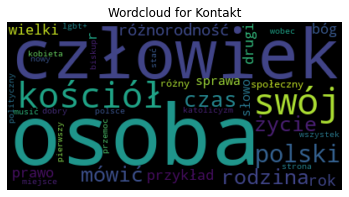

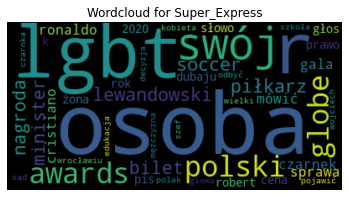

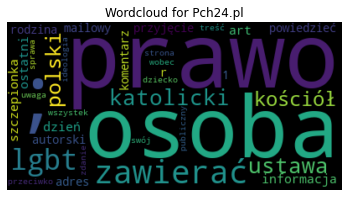

In [11]:
frequency = {}

for key, value in data_dict.items():
    frequency[key] = make_wordclouds(value,key)

In [12]:
pd.Series(frequency["wPolityce.pl"]).sort_values(ascending=False).head(50)

lgbt           3561
polski         2784
prawo          2560
prezydent      2186
swój           2002
mówić          1967
osoba          1886
               1886
człowiek       1781
polsce         1502
sprawa         1495
powiedzieć     1362
duda           1346
ideologia      1151
dziecko        1135
rząd           1084
państwo        1034
rok            1027
europejski     1012
wybór          1003
kobieta         969
kraj            959
wszystek        959
czas            956
nowy            932
strona          920
r               912
pis             896
aktywista       896
środowisko      857
rodzina         840
trzaskowski     839
wielki          834
słowo           814
wyborczy        772
kościół         753
działanie       749
wobec           745
sytuacja        744
warszawa        743
musić           701
wiedzieć        698
władza          694
policja         680
stać            676
sąd             665
ważny           662
polityczny      660
lewica          658
opozycja        650


In [13]:
pd.Series(frequency["OKO.press"]).sort_values(ascending=False).head(50)

the           5267
of            3411
lgbt          2056
and           1743
prawo         1653
osoba         1652
polski        1338
in            1252
człowiek       907
ideologia      896
mówić          872
swój           824
r              824
dziecko        741
               737
polsce         661
sprawa         630
rodzina        620
rok            589
duda           584
prezydent      535
europejski     531
gmina          523
oko            518
kościół        515
that           514
pis            512
władza         509
publiczny      493
państwo        489
“              484
uchwała        460
czas           456
2019           438
wszystek       434
as             415
działanie      407
społeczny      405
with           401
życie          396
rada           385
wartość        384
kraj           380
miasto         374
wolność        365
town           361
ideology       360
local          353
council        352
wobec          352
dtype: int64

Simple frequencies do not show much variety in language used in articles from different media. This part of analysis shows that the media relate to the same events, such as presidential elecion, that were prominent in discussion about LGBT+ community in Poland in 2020.

#### 2.3 Looking for common collocations

In [16]:
# creating a dictionary for collocations in each data frame

collocations = {}
# reading tokens from processed data for each data frame
for key in data_dict:
    collocations[key] = find_collocations_bigram(data_dict[key])

In [17]:
for key in collocations:
    print(f"Common collocations for {key}")
    for attribute, value in collocations[key].items():
        print(f"{attribute}:{value}")
    print("\n\n ---------------------------")


Common collocations for wPolityce.pl
('aktywista', 'lgbt'):(553.0, 0.0008225127541534663)
('ideologia', 'lgbt'):(462.0, 0.0006871625541028959)
('andrzej', 'duda'):(401.0, 0.0005964332991239421)
('andrzeja', 'duda'):(394.99999999999994, 0.0005875091101096187)
('rafał', 'trzaskowski'):(380.00000000000006, 0.0005651986375738105)
('środowisko', 'lgbt'):(321.0, 0.0004774441122662978)
('prawo', 'człowiek'):(312.0, 0.0004640578287448128)
('osoba', 'lgbt'):(287.0, 0.00042687370785179896)
('strefa', 'wolny'):(272.0, 0.00040456323531599063)
('rafała', 'trzaskowskiego'):(249.0, 0.0003703538440944179)
('prezydent', 'duda'):(243.99999999999997, 0.0003629170199158151)
('unia', 'europejski'):(236.00000000000003, 0.00035101810123005074)
('michała', 'sz'):(233.0, 0.00034655600672288904)
('krakowski', 'przedmieście'):(221.0, 0.0003287076286942424)
('tęczowy', 'flaga'):(218.0, 0.00032424553418708077)
('komisja', 'europejski'):(194.0, 0.00028854877812978745)
('wybór', 'prezydencki'):(187.0, 0.000278137224

('warto', 'wybrać'):(9.0, 0.00010118043844856661)
('wartość', 'korzystać'):(9.0, 0.00010118043844856661)
('watykański', 'ii'):(9.0, 0.00010118043844856661)
('ważny', 'pojęcie'):(9.0, 0.00010118043844856661)
('ważny', '‒'):(9.0, 0.00010118043844856661)
('wciąż', 'niebezpieczny'):(9.0, 0.00010118043844856661)
('wciąż', 'szją'):(9.0, 0.00010118043844856661)
('wcześnie', 'próbować'):(9.0, 0.00010118043844856661)
('wdzięczny', 'pożywka'):(9.0, 0.00010118043844856661)
('wewnętrzny', 'życie'):(9.0, 0.00010118043844856661)
('who', 'cares'):(9.0, 0.00010118043844856661)
('wiadomo', 'prawdziwy'):(9.0, 0.00010118043844856661)
('wiara', 'pozwalać'):(9.0, 0.00010118043844856661)
('wiarygodny', 'zwłaszcza'):(9.0, 0.00010118043844856661)
('widzieć', 'chrześcijanin'):(9.0, 0.00010118043844856661)
('wieko', 'zmienić'):(9.0, 0.00010118043844856661)
('wielki', 'obawa'):(9.0, 0.00010118043844856661)
('wielki', 'przeciwnik'):(9.0, 0.00010118043844856661)
('wielki', 'szansa'):(9.0, 0.00010118043844856661)
(

Most common bigram collocations show much more differences. For example, one of the most common collocation in right wing outlets, like wPolityce.pl and Niezalezna.pl is Michał Sz., deliberate misgendering of LGBT activist Margot. There are also numerous mentions of "Figura Chrystusa", refering to an act of hanging rainbow flag on one of Christ monuments in Warsaw, seen as act of desacration. There are also mentions of "gender ideology", right wing term for modern emancipation movements. Pope John Paul II is frequently brought up, much more often than polish Prime Minister. Right wing media often refers to offence of religious beliefs, where left wing outlets more frequently bring up hate speech. There are also mentions of marriage equality, human rights, gender identity, heteronormativity and so on. This material could be used to more detailed qualitative analysis.

In [18]:
# creating trigram collocations
# defining punctuation, creating a dictionary for collocations in each data frame
collocations_trigram = {}

# reading tokens from processed data in each data frame
for key in data_dict:
    collocations_trigram[key] = find_collocations_trigram(data_dict[key])

In [19]:
for key in collocations_trigram:
    print(f"Common collocations for {key}")
    for attribute, value in collocations_trigram[key].items():
        print(f"{attribute}:{value}")
    print("\n\n ---------------------------")


Common collocations for wPolityce.pl
('prezydent', 'andrzeja', 'duda'):(169.0, 0.0002513646572367736)
('prezydent', 'andrzej', 'duda'):(158.0, 0.0002350036440438475)
('jana', 'paweł', 'ii'):(115.0, 0.0001710469561078637)
('rzecznik', 'prawo', 'obywatelski'):(107.99999999999999, 0.0001606354022578198)
('von', 'dera', 'leyen'):(82.0, 0.00012196391652908543)
('łódzki', 'kurator', 'oświata'):(63.0, 9.370398465039489e-05)
('prawo', 'osoba', 'lgbt'):(49.0, 7.288087695030714e-05)
('premiera', 'mateusz', 'morawiecki'):(48.0, 7.139351211458659e-05)
('tura', 'wybór', 'prezydencki'):(47.0, 6.990614727886603e-05)
('ii', 'wojna', 'światowy'):(46.0, 6.841878244314548e-05)
('zły', 'strona', 'historia'):(46.0, 6.841878244314548e-05)
('mówić', 'ów', ' '):(45.00000000000001, 6.693141760742493e-05)
('jan', 'paweł', 'ii'):(44.0, 6.544405277170437e-05)
('michała', 'sz', 'margot'):(41.0, 6.098195826454271e-05)
('radio', 'nowy', 'świat'):(41.0, 6.098195826454271e-05)
('rozmawiać', 'anna', 'wiejak'):(41.0, 6.

('13', 'czerwiec', '2020'):(6.999999999999999, 1.9384191914576634e-05)
('7', 'sierpień', '2020'):(6.999999999999999, 1.9384191914576634e-05)
('anna', 'maria', 'żukowska'):(6.999999999999999, 1.9384191914576634e-05)
('ciąg', 'ostatni', 'pięć'):(6.999999999999999, 1.9384191914576634e-05)
('czas', 'ii', 'wojna'):(6.999999999999999, 1.9384191914576634e-05)
('degli', 'studi', 'di'):(6.999999999999999, 1.9384191914576634e-05)
('dotyczyć', 'osoba', 'lgbt'):(6.999999999999999, 1.9384191914576634e-05)
('fundacja', 'prawo', 'człowiek'):(6.999999999999999, 1.9384191914576634e-05)
('kampania', 'przeciwko', 'homofobia'):(6.999999999999999, 1.9384191914576634e-05)
('kodeks', 'postępowanie', 'karny'):(6.999999999999999, 1.9384191914576634e-05)
('lipiec', '2020', 'r'):(6.999999999999999, 1.9384191914576634e-05)
('marszałek', 'pięć', 'województwo'):(6.999999999999999, 1.9384191914576634e-05)
('międzynarodowy', 'stowarzyszenie', 'lesbijka'):(6.999999999999999, 1.9384191914576634e-05)
('oko', ' ', 'piątk

Numerous other differences, indicating ideological difference can be found in trigram collocations. Again, right wing press very often invokes deceased polish pope, misgenders Margot, talk about desacration, offence of religious beliefs and deviation. Most often mentioned university is Catholic University of Lublin. There are mentions of lgbt provocations, destruction of property and deception. Left leaning ones make more mentions of lgbt+ rights, discrimination, and mention multiple NGOs. Again, this data could be a valuable base for further qualitative analysis

##### 2.3.2 Looking for collocations with the term LGBT

In [21]:
# looking for collocations with lgbt related terms

collocations_lgbt = {}
# reading tokens from processed data for each data frame
for key in data_dict:
    collocations_lgbt[key] = find_collocations_trigram(data_dict[key],key="lgbt")

In [22]:
collocations_lgbt["wPolityce.pl"]

{('prawo', 'osoba', 'lgbt'): (49.0, 7.288087695030714e-05),
 ('hucpa', 'działacz', 'lgbt'): (34.0, 5.057040441449883e-05),
 ('lgbt', 'zbezcześcić', 'figura'): (33.0, 4.908303957877828e-05),
 ('działacz', 'lgbt', 'zbezcześcić'): (32.0, 4.7595674743057726e-05),
 ('prowokacja', 'aktywista', 'lgbt'): (29.0, 4.313358023589606e-05),
 ('wprowadzić', 'karta', 'lgbt'): (28.0, 4.164621540017551e-05),
 ('wobec', 'ideologia', 'lgbt'): (25.0, 3.718412089301385e-05),
 ('ambasador', 'ws', 'lgbt'): (24.0, 3.5696756057293295e-05),
 ('ws', 'społeczność', 'lgbt'): (24.0, 3.5696756057293295e-05),
 ('przedmieście', 'aktywista', 'lgbt'): (21.0, 3.123466155013163e-05),
 ('wobec', 'osoba', 'lgbt'): (21.0, 3.123466155013163e-05)}

#### 2.2 and 2.3 summary
Obtained data containing common collocations in texts from different sites, including collocations with the term lgbt, can be used in qualitative analysis. By showing how commonly used expressions are positively or negatively charged and investigating metaphors they portray we can reconstruct how these text influence readers. More advanced machine learning models, such as neural networks trained for sentiment analysis of sentences or collocations could be employed in such work.

### 3. Does right wing newspapers have distinctly different style than left leaning ones?
#### Classification using machine learning models

Learning will be done on three most distinctly right-leaning portals in the corpus: wPolityce.pl, Niezalezna.pl and PCH24.pl and three most distinctly left wing: OKO.press, Krytyka Polityczna and Kontakt. Left wing part will be significantly smaller than the right wing, so the training set will not be perfectly balanced. Training model on atricles from different sites will provide variety of languages used. Final model can be used to mark articles on lgbt issues to check if the language used is closer to the left-wing coverage (more lgbt friendly) or right-wing one (hostile towards lgbt community).

Texts passed to CountVectorizer will be already lemmatized articles transformed back into strings.

In [25]:
# preparing learning set from texts
keys_right = ["Pch24.pl","wPolityce.pl","Niezalezna.pl"]
keys_left = ["OKO.press","Kontakt","Krytyka_Polityczna"]

# learning dataframe has two values, ideological side of the text publisher and article text
learning_set = pd.DataFrame({"Side":[], "Text":[]})
learning_set

# preparing articles from right leaning outlets
for key in keys_right:
    texts = data_dict[key].processed
    texts_lemmatized = []
    for text in texts:
        text = " ".join(str(x.lemma_) for x in text)
        texts_lemmatized.append(text)
    frame = pd.DataFrame({"Side":"right","Text":texts_lemmatized})
    learning_set = learning_set.append(frame,ignore_index=True)

# preparing articles from left leaning outlets
for key in keys_left:
    texts = data_dict[key].processed
    texts_lemmatized = []
    for text in texts:
        text = " ".join(str(x.lemma_) for x in text)
        texts_lemmatized.append(text)
    frame = pd.DataFrame({"Side":"left","Text":texts_lemmatized})
    learning_set = learning_set.append(frame,ignore_index=True)

In [27]:
# creating variables, defining training and testing sets
X = learning_set.Text
y = learning_set.Side
# changing labels to numerical values
y = y.map({"right":0,"left":1})
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [28]:
"""
creating grid search to find the best classification model
every model uses count vectorizer to change texts into numerical vectors
I'm not using vectors provided by Spacy in earlier preprocessing, because CountVectorizer can be fitted into a pipeline and is
easier to process by classification models. Spacy vectors caused problems in fitting phase of learning.
"""
pipelines = [make_pipeline(CountVectorizer(),LogisticRegression(solver="liblinear")), # Logistic Regression
            make_pipeline(CountVectorizer(),DecisionTreeClassifier()),                # Decision Tree
            make_pipeline(CountVectorizer(),MultinomialNB()),                         # Naive Bayes
            make_pipeline(CountVectorizer(),SVC()),                                   # SVM
            make_pipeline(CountVectorizer(),SVC()),                                   # SVM2
            make_pipeline(CountVectorizer(),RandomForestClassifier())]                     # Bagging Classifier

# Defining parameters to check for each defined model
param_grids = [{"logisticregression__penalty":["l1","l2"],"logisticregression__C":[0.001,0.01,0.1,1,10,100,1000]},
              {"decisiontreeclassifier__criterion":["gini","entropy"],"decisiontreeclassifier__min_samples_split":[2,4,6,8,10]},
              {"multinomialnb__fit_prior":[True,False],"multinomialnb__alpha":[0.1,0.3,0.5,0.7,0.9]},
              {"svc__kernel":["rbf"],"svc__C":[0.01,0.1,1,10,100,1000,10000],"svc__gamma":[0.1,0.2,1,10,20,50]},
              {"svc__kernel":["poly"],"svc__C":[0.01,0.1,1,10,100,1000,10000,100000],"svc__degree":[1,2,3]},
              {"randomforestclassifier__criterion":["gini","entropy"],
              "randomforestclassifier__n_estimators":[100,200,300], "randomforestclassifier__min_samples_split":[2,4,6,8,10]}]

In [29]:
# using grid search cv to find the best model

# defining variables to store parameters and scores for the best model
best_model = ""
best_params = ""
score_f1 = 0
acc_score = 0

# testing in a loop for each pipeline - parameters combination
for i in range(len(pipelines)):
    
    # Creating GridSearch object
    grid = GridSearchCV(pipelines[i],
                        param_grid=param_grids[i],
                        refit=True,      # refitting best model
                        cv = 5,          # nr of crossvalidations
                        verbose=3,       # provides information during the learning process
                        n_jobs = 3)      # nr of cores used for testing
    
    # Fitting data
    grid.fit(X_train,y_train)
    
    # Predicting on test data, scoring
    y_pred = grid.predict(X_test)
    test_f1 = f1_score(y_test,y_pred)
    test_acc = accuracy_score(y_test,y_pred)
    
    # Checking if model is better than current best, declaring new values if it is
    if test_f1 > score_f1:
        acc_score = test_acc
        score_f1 = test_f1
        best_model = pipelines[i]
        best_params = grid.best_params_
        

# printing best model 
print(f"Best model: {best_model} with {best_params} parameters. F1 score = {score_f1} and Accuracy score = {acc_score}")

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   22.9s
[Parallel(n_jobs=3)]: Done  70 out of  70 | elapsed:   48.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   15.5s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   28.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   11.9s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   22.4s finished


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  6.1min
[Parallel(n_jobs=3)]: Done 210 out of 210 | elapsed: 10.4min finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   32.4s
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:  2.4min finished


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   23.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  1.8min
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:  2.2min finished


Best model: Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression', LogisticRegression(solver='liblinear'))]) with {'logisticregression__C': 100, 'logisticregression__penalty': 'l1'} parameters. F1 score = 0.9 and Accuracy score = 0.9719298245614035


In [ ]:
# retraining best model on whole dataset:

model = best_model.fit(X,y)

In [ ]:
# Saving trained best model

filename = 'Ideological_text_classifier_lgbt.sav'
pickle.dump(model,open(filename, 'wb'))

Let's try to achieve better score with XGBoost Classifier - trained separately because it's training takes significantly longer, so instead of GridSearch, RandomizedSearch is used

In [30]:
pipeline = make_pipeline(CountVectorizer(),XGBClassifier())
params = {"xgbclassifier__n_estimators":[10,100,200],
         "xgbclassifier__learning_rate":ss.uniform(0.01,0.3),
          "xgbclassifier__max_depth": ss.randint(5,30),
         "xgbclassifier__min_child_weight":ss.randint(5,50),
         "xgbclassifier__reg_lambda":ss.uniform(0.1,3),
         "xgbclassifier__tree_method":["auto","approx","hist"]}
grid = RandomizedSearchCV(pipeline,
                        param_distributions=params,
                        n_iter = 50,
                        refit=True,      # refitting best model
                        cv = 5,          # nr of crossvalidations
                        verbose=3,       # provides information during the learning process
                        n_jobs = 3)

grid.fit(X_train,y_train)
print(grid.score(X_test,y_test))
y_pred = grid.predict(X_test)
scr_f1 = f1_score(y_test,y_pred)
print(scr_f1)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed: 10.8min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed: 19.9min finished


0.9719298245614035
0.9012345679012346


In [31]:
grid.best_params_

{'xgbclassifier__learning_rate': 0.1681742693634553,
 'xgbclassifier__max_depth': 8,
 'xgbclassifier__min_child_weight': 8,
 'xgbclassifier__n_estimators': 200,
 'xgbclassifier__reg_lambda': 2.6773088236585756,
 'xgbclassifier__tree_method': 'hist'}

XGBoost achieved slightly better results than LogisticRegression, so it's saved as the best classifier

In [33]:
best_model = make_pipeline(CountVectorizer(),XGBClassifier(learning_rate=0.1681742693634553,max_depth=8,min_child_weight=8,
                                                      n_estimators=200,reg_lambda=2.6773088236585756, tree_method="hist"))

model = best_model.fit(X,y)
filename = 'Ideological_text_classifier_lgbt.sav'
pickle.dump(model,open(filename, 'wb'))

Almost all classifiers yielded very good results in classificating texts, indicating that there is significant difference between right and left wing press in regards to coverage of lgbt+ community issues. This model can be employed to check whether new texts use aggressive and hostile or more empathetic language.